# PhenEx Study Tutorial
In this page we will show you how to use PhenEx to :
1. Connect to a Snowflake Database
2. Work with OMOP data
3. Create a simple cohort
4. View cohort summary statistics

First make sure that your PhenEx version is up to date

In [1]:
# For updating PhenEx to latest released version
# !pip install -Uq PhenEx
%pip install -e /Users/ahartens/src/PhenEx


Obtaining file:///Users/ahartens/src/PhenEx
  Preparing metadata (setup.py) ... done
  Attempting uninstall: phenex
    Found existing installation: phenex 0.7.0
    Uninstalling phenex-0.7.0:
      Successfully uninstalled phenex-0.7.0
  DEPRECATION: Legacy editable install of phenex==0.7.0 from file:///Users/ahartens/src/PhenEx (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for phenex

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import ibis
ibis.options.interactive = True

## Set Snowflake Credentials
PhenEx needs to connect to a Snowflake backend and therefore needs your login credentials. There are two ways to do this : (1) explicitly or (2) using an .env (dot env) file. We show how to do both, but only do one!
### Method 1 : manual entry

In [3]:
# import os

# # authentication
# os.environ.update({
#     'SNOWFLAKE_ACCOUNT':'ACOUNT',
#     'SNOWFLAKE_WAREHOUSE':'WAREHOUSE'
#     'SNOWFLAKE_ROLE':'ROLE'
#     'SNOWFLAKE_USER':'USER'
# })

### Method 2 : env file
You can also specify these with using a dotenv file (https://github.com/motdotla/dotenv). One advantage to doing this is that you do not put sensitive credential information into your jupyter notebook.

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

If you see True above, it means python was able to find and load your environment file.



## Connect to the database

We will now establish a connection to Snowflake using a SnowflakeConnector; these connectors will use your environment variables (set above) for login credentials.

At this point we must define two databases in Snowflake:
1. Source : the snowflake location where input data to phenex should come from
2. Destination (dest) : the snowflake location where output data from phenex should be written. The destination will be created if it does not exist.

Run this cell to connect to these databases; this cell will open up two browser tabs (if you're using browser authentication). After those pages load (wait for them to say completed!), close them and return to this notebook.

In [5]:
%%capture
from phenex.ibis_connect import SnowflakeConnector

con = SnowflakeConnector(
    # SNOWFLAKE_SOURCE_DATABASE = 'SOURCE_DATABASE', # enter these, use or use the .env file
    # SNOWFLAKE_DEST_DATABASE = 'DEST_DATABASE'      # enter these, use or use the .env file
)

Notice that both of these locations can also be specified using environment variables (like we did in method 1/2 for credentials), and vice versa (credentials can be passed to a connector as keyword arguments, rather being hidden in the .env file). However, as credentials generally remain the same between projects and the database locations are project dependent, it is best practice to define database locations with the connector.


## Define input data structure

PhenEx needs to know a little bit about the structure of the input data in order to help us make phenotypes and cohorts.

What this means is that PhenEx knows in what table and column to find information such as patient id, year of birth, diagnosis events, etc. This information is generally present in all RWD sources, but for each data source, is (1) organized in a different way and (2) can have different column names.

When using a new data source, we need to onboard that database for usage with PhenEx (tell it about table structure and column names). Go to the [tutorial on onboarding a new database](/2_Onboarding_New_Database.ipynb) to learn how to onboard a database.

For the purposes of this tutorial, we will be using OMOP data, which is already onboarded and available in the PhenEx library. All we have to do is import the OMOPDomains and then get the mapped tables.

In [6]:
from phenex.mappers import OMOPDomains
mapped_tables = OMOPDomains.get_mapped_tables(con)
list(mapped_tables.keys())

['PERSON',
 'VISIT_OCCURRENCE',
 'VISIT_DETAIL',
 'CONDITION_OCCURRENCE',
 'DEATH',
 'PROCEDURE_OCCURRENCE',
 'DRUG_EXPOSURE',
 'CONDITION_OCCURRENCE_SOURCE',
 'PROCEDURE_OCCURRENCE_SOURCE',
 'DRUG_EXPOSURE_SOURCE',
 'PERSON_SOURCE',
 'OBSERVATION_PERIOD',
 'OBSERVATION',
 'MEASUREMENT']

### Looking at input data
PhenEx bundles all input data into a dictionary, in this case in the variable called mapped_tables. The keys in this dictionary are known as 'domains'; we can access the input data by these domain keys. The values for each key are the actual tables

## Integrating medical codelists
Medical codelists are an integral part of any observational study. PhenEx has functionality to help you use medical codelist files (CSVs or Excels). Go to the Codelist Tutorial to find out more about codelists. For the purpose of this tutorial, we will create a LocalCSVCodelistFactory that opens a codelist file, and returns medical codelists ready for use with PhenEx.

In [7]:
from phenex.codelists import LocalCSVCodelistFactory

# create the codelist factory. We have to map column names; see the Codelist Tutorial for more info
codelist_factory = LocalCSVCodelistFactory(
    path='./codelists_for_tutorial.csv',
    name_code_column='CONCEPT_ID',
    name_codelist_column='CODELIST',
    name_code_type_column = 'VOCABULARY_ID'
)

# let's see what codelists are available
codelist_factory.get_codelists()

['MYOCARDIAL_INFARCTION', 'ATRIAL_FIBRILLATION']

## Study Definition
Now we're ready to use PhenEx to specify our observational study! For the purposes of this tutorial, we will use the following dummy study definition:


**AIM** : to characterize patients with atrial fibrillation

**Entry Criterion**

incident atrial fibrillation, as defined by the first occurrence of a diagnosis code for atrial fibrillation

**Inclusion criteria**

1. At least one year lookback period
2. greater than or equal to 18 years old

**Exclusion criteria**
1. No myocardial hospitalization in the year prior to index

**Baseline characteristics**
1. age at index
2. sex
3. number of deaths within 30 days of index


**Time to event analysis** for death post index


To use PhenEx, we'll translate this written text to a PhenEx executable study definition. We do that by creating a phenotype for each one of these study elements, and then we will put them all together in the 'Cohort' section

### Entry criterion
The entry criterion defines study entry i.e. it defines the index date. At this point, it is only a potential index date; only after we evaluate the in/exclusion criteria at this possible index date does it become the true index date.

In [8]:
from phenex.phenotypes.codelist_phenotype import CodelistPhenotype
from phenex.codelists.codelists import Codelist

# create a codelist for atrial fibrillation
cl_af = codelist_factory.get_codelist('ATRIAL_FIBRILLATION').copy(use_code_type=False)

# create a phentype that uses this codelist.
pt_entry = CodelistPhenotype(
    name='first_atrial_fibrillation_diagnosis',
    domain='CONDITION_OCCURRENCE',
    codelist=cl_af,
    return_date='first', # return the first occurrence
)

In [9]:
# we can execute the phenotype and look at the results. this is not required!
pt_entry.execute(mapped_tables)
pt_entry.table

┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ PERSON_ID ┃ BOOLEAN ┃ EVENT_DATE ┃ VALUE ┃
┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ int64     │ boolean │ date       │ int32 │
├───────────┼─────────┼────────────┼───────┤
│ 329592325 │ True    │ 2020-06-28 │  NULL │
│ 575557186 │ True    │ 2018-11-26 │  NULL │
│ 128302105 │ True    │ 2017-04-17 │  NULL │
│ 251261273 │ True    │ 2018-05-01 │  NULL │
│ 435289610 │ True    │ 2015-12-07 │  NULL │
│ 155364699 │ True    │ 2017-11-22 │  NULL │
│ 393848327 │ True    │ 2017-11-17 │  NULL │
│ 342742502 │ True    │ 2020-06-19 │  NULL │
│ 347573062 │ True    │ 2022-07-28 │  NULL │
│ 219363819 │ True    │ 2020-02-24 │  NULL │
│         … │ …       │ …          │     … │
└───────────┴─────────┴────────────┴───────┘

### Inclusions
We now create a list of inclusion phenotypes; these phenotypes must evaluate to 'true' to enter the cohort i.e patients must fulfill the criteria defined by the inclusion phenotypes. We go one by one, implementing each criterium.
#### Inclusion 1 : One year continuous coverage

In [10]:
from phenex.phenotypes import TimeRangePhenotype
from phenex.filters import RelativeTimeRangeFilter, GreaterThanOrEqualTo

pt_inclusion1 = TimeRangePhenotype(
    name = 'one_year_coverage',
    relative_time_range=RelativeTimeRangeFilter(
        when='before',
        min_days=GreaterThanOrEqualTo(365),
        anchor_phenotype=pt_entry # this is only necessary if we want to execute pt_inclusion1 outside of a cohort.
    )
)

# we can again execute immediately (outside of the Cohort) if we want to observe the results
# pt_inclusion1.execute(mapped_tables)

#### Inclusion 2 : Age greater than 18

In [11]:
from phenex.phenotypes import AgePhenotype
from phenex.filters import ValueFilter, GreaterThan

pt_inclusion2 = AgePhenotype(
    name = 'age_g18',
    value_filter = ValueFilter(
        min_value=GreaterThan(18)
    ),
    anchor_phenotype=pt_entry # this is only necessary if we want to execute pt_inclusion1 outside of a cohort.
)

# we can again execute immediately (outside of the Cohort) if we want to observe the results
# pt_inclusion2.execute(mapped_tables)

In [12]:
# Create the final list of includions. These criteria will be executed sequentially when creating the attrition table, so adjust the order as desired for the attrition table.
inclusions = [pt_inclusion1, pt_inclusion2]

### Exclusions
We now create a list of exclusion phenotypes; these phenotypes must evaluate to 'false' to enter the cohort i.e patients may NOT fulfill the criteria defined by the exclusion phenotypes. We go one by one, implementing each criterium.

#### Exclusion 1 : Inpatient myocardial infarction diagnosis

In [13]:

from phenex.filters import GreaterThan
from phenex.filters.categorical_filter import CategoricalFilter
from phenex.filters import CategoricalFilter, RelativeTimeRangeFilter, GreaterThanOrEqualTo, LessThan

f_inpatient = CategoricalFilter(
    allowed_values = [
        9203,   #Emergency Room Visit
        262,    #Emergency Room and Inpatient Visit
        9201,   #Inpatient Visit
    ],
    column_name = 'VISIT_CONCEPT_ID',
    domain = 'VISIT_OCCURRENCE'
)


f_one_year_pre_index = RelativeTimeRangeFilter(
    when='before',
    anchor_phenotype=pt_entry, # this is only necessary if we want to execute pt_inclusion1 outside of a cohort.
    min_days=GreaterThanOrEqualTo(0),
    max_days=LessThan(365), 
)

cl_mi = codelist_factory.get_codelist('MYOCARDIAL_INFARCTION').copy(use_code_type=False)

pt_exclusion1 = CodelistPhenotype(
    name='myocardial_infarction_hospitalization',
    domain='CONDITION_OCCURRENCE',
    codelist=cl_mi,
    categorical_filter=f_inpatient,
    relative_time_range=f_one_year_pre_index
)

# we can again execute immediately (outside of the Cohort) if we want to observe the results; patients in this table will be EXCLUDED from the final cohort
# pt_exclusion1.execute(mapped_tables)

In [14]:
exclusions = [pt_exclusion1]

### Characteristics
We now create a list of baseline characteristic phenotypes; these phenotypes are run on the final cohort only. We can observe the results in Table1. We go one by one, implementing each criterium.


In [16]:
from phenex.phenotypes import AgePhenotype, BinPhenotype, CategoricalPhenotype, DeathPhenotype

pt_characteristic1 = AgePhenotype()
pt_characteristic2 = BinPhenotype(name='binned_age',phenotype=pt_characteristic1)

pt_characteristic3 = CategoricalPhenotype(
    name = 'sex',
    categorical_filter=CategoricalFilter(column_name="GENDER_SOURCE_VALUE"), domain = "PERSON"
)

pt_characteristic4 = DeathPhenotype(
    name='death_30days',
    domain='DEATH',
    relative_time_range=RelativeTimeRangeFilter(
        when='after',
        min_days=GreaterThan(0),
        max_days=LessThan(30)
    )
)

characteristics = [pt_characteristic1, pt_characteristic2, pt_characteristic3, pt_characteristic4]

### Outcomes
We now create a list of outcome phenotypes; these phenotypes are run on the final cohort only. We can observe the results in a time to event analysis. We go one by one, implementing each criterium.


In [17]:
f_postindex = RelativeTimeRangeFilter(
    when='after',
    min_days=GreaterThan(0),
)


pt_outcome1 = CodelistPhenotype(
    name='myocardial_infarction_after_index',
    domain='CONDITION_OCCURRENCE',
    codelist=cl_mi,
    categorical_filter=f_inpatient,
    relative_time_range=f_postindex
)



In [18]:
outcomes = [pt_outcome1]

### Cohort
We now put everything together in a PhenEx cohort. This takes the entry phenotype, and all the lists of phenotypes we created above. We can then execute the cohort.

In [19]:
from phenex.phenotypes.cohort import Cohort

cohort = Cohort(
    name = 'study_tutorial_cohort',
    entry_criterion=pt_entry,
    inclusions=inclusions,
    exclusions=exclusions,
    characteristics=characteristics,
    outcomes = outcomes,
)

2025-09-09 12:45:17,265 - phenex.phenotypes.cohort - INFO - Cohort 'study_tutorial_cohort' initialized with entry criterion 'FIRST_ATRIAL_FIBRILLATION_DIAGNOSIS'


In [20]:
cohort.execute(mapped_tables, con = con, n_threads=6, overwrite=True, lazy_execution=True)

2025-09-09 12:45:20,863 - phenex.phenotypes.cohort - INFO - Cohort 'study_tutorial_cohort': executing entry stage ...
2025-09-09 12:45:22,351 - phenex.phenotypes.cohort - INFO - Cohort 'study_tutorial_cohort': completed entry stage.
2025-09-09 12:45:22,352 - phenex.phenotypes.cohort - INFO - Cohort 'study_tutorial_cohort': executing index stage ...
2025-09-09 12:45:24,457 - phenex.phenotypes.cohort - INFO - Cohort 'study_tutorial_cohort': completed index stage.
2025-09-09 12:45:24,458 - phenex.phenotypes.cohort - INFO - Cohort 'study_tutorial_cohort': executing reporting stage ...


┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┓
┃ PERSON_ID ┃ BOOLEAN ┃ EVENT_DATE ┃ VALUE ┃ INDEX_DATE ┃
┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━┩
│ int64     │ boolean │ date       │ int64 │ date       │
├───────────┼─────────┼────────────┼───────┼────────────┤
│ 314835952 │ True    │ 2020-11-13 │  NULL │ 2020-11-13 │
│ 760829119 │ True    │ 2017-11-17 │  NULL │ 2017-11-17 │
│ 773915894 │ True    │ 2022-08-18 │  NULL │ 2022-08-18 │
│ 399177003 │ True    │ 2015-12-15 │  NULL │ 2015-12-15 │
│ 141972639 │ True    │ 2021-09-01 │  NULL │ 2021-09-01 │
│  84546653 │ True    │ 2016-06-13 │  NULL │ 2016-06-13 │
│ 212220818 │ True    │ 2019-07-23 │  NULL │ 2019-07-23 │
│ 257386722 │ True    │ 2021-07-02 │  NULL │ 2021-07-02 │
│ 253280606 │ True    │ 2022-01-21 │  NULL │ 2022-01-21 │
│ 241072434 │ True    │ 2021-02-01 │  NULL │ 2021-02-01 │
│         … │ …       │ …          │     … │ …          │
└───────────┴─────────┴────────────┴───────┴────────────┘

## Reporting
Once you're done executing the cohort, PhenEx provides basic reporting of attrition, baseline characteristics, and time to event.
### Attrition
The attrition table shows the flow of patients to result in your final cohort. The first row is the entry criterion. 
- The N column shows how many patients in the entire dataset fulfill the entry criterium. The N column in the following rows shows how many patients that fulfill the entry criterium fulfill the criterium on that row.
- The Remaining column shows how many patients remain after applying the criterium on that row.
- The % column shows how many remaining, as a percentage of the entry criterium
- The delta column shows how many patients are lost after applying the criterium on each row

In [21]:
from phenex.reporting import Waterfall

reporter = Waterfall()
reporter.execute(cohort)

2025-09-09 12:45:39,923 - phenex.reporting.waterfall - DEBUG - Beginning execution of waterfall. Calculating N patents
2025-09-09 12:45:40,406 - phenex.reporting.waterfall - DEBUG - Cohort has 72798 patients
2025-09-09 12:45:41,221 - phenex.reporting.waterfall - DEBUG - Starting inclusion criteria ONE_YEAR_COVERAGE
2025-09-09 12:45:42,586 - phenex.reporting.waterfall - DEBUG - Finished inclusion criteria ONE_YEAR_COVERAGE: N = 80974 waterfall = 80974
2025-09-09 12:45:42,591 - phenex.reporting.waterfall - DEBUG - Starting inclusion criteria AGE_G18
2025-09-09 12:45:44,024 - phenex.reporting.waterfall - DEBUG - Finished inclusion criteria AGE_G18: N = 101538 waterfall = 80911
2025-09-09 12:45:44,027 - phenex.reporting.waterfall - DEBUG - Starting exclusion criteria MYOCARDIAL_INFARCTION_HOSPITALIZATION
2025-09-09 12:45:45,267 - phenex.reporting.waterfall - DEBUG - Finished exclusion criteria MYOCARDIAL_INFARCTION_HOSPITALIZATION: N = 9744 waterfall = 72798


,Type,Name,N,Remaining,%,Delta
0,entry,First atrial fibrillation diagnosis,101624,101624,100.0,
1,inclusion,One year coverage,80974,80974,79.7,-20650
2,,Age g18,101538,80911,79.6,-63
3,exclusion,Myocardial infarction hospitalization,9744,72798,71.6,-8113
4,final_cohort,,,72798,71.6,


### Table 1
We can look at summary statistics of our baseline characteristics using PhenEx. The order of the phenotypes in the list of characteristics determines the order in Table1.
- The N column shows how many patients that fulfill the entry criterium fulfill the criterium on that row
- The % column shows the percentage of patients that fulfill the entry criterium have the criterium on that row
- For categorically valued phenotypes (e.g Categorical Phenotype, BinPhenotype), we see a row for each category found
- For numerically valued phenotypes (e.g. MeasurementPhenotype, AgePhenotype), we see summary statistics

In [22]:
cohort.table1

2025-09-09 12:45:46,850 - phenex.phenotypes.cohort - DEBUG - Generating Table1 report ...
2025-09-09 12:45:47,097 - phenex.reporting.table1 - DEBUG - Starting with categorical columns for table1
2025-09-09 12:45:47,098 - phenex.reporting.table1 - DEBUG - Found 2 : ['BINNED_AGE', 'SEX']
2025-09-09 12:45:48,334 - phenex.reporting.table1 - DEBUG - Starting with boolean columns for table1
2025-09-09 12:45:48,340 - phenex.reporting.table1 - DEBUG - Found 1 : ['DEATH_30DAYS']
2025-09-09 12:45:48,675 - phenex.reporting.table1 - DEBUG - Starting with value columns for table1
2025-09-09 12:45:48,678 - phenex.reporting.table1 - DEBUG - Found 1 : ['AGE']
2025-09-09 12:45:51,155 - phenex.reporting.table1 - DEBUG - Finished creating table1
2025-09-09 12:45:51,163 - phenex.phenotypes.cohort - DEBUG - Table1 report generated.


,Name,N,%,Mean,STD,Median,Min,Max
0,Cohort,72798,100.0,,,,,
1,Age,72798,100.0,71.3,11.2,74.0,19.0,89.0
2,Binned age=[10-20),8,0.0,,,,,
3,Binned age=[20-30),319,0.4,,,,,
4,Binned age=[30-40),856,1.2,,,,,
5,Binned age=[40-50),2299,3.2,,,,,
6,Binned age=[50-60),7180,9.9,,,,,
7,Binned age=[60-70),16010,22.0,,,,,
8,Binned age=[70-80),23816,32.7,,,,,
9,Binned age=[80-90),22310,30.6,,,,,


### Time to event analysis
PhenEx allows you do to basic time to event analyses. KaplanMeier curves are currently supported. You simply define your right censoring phenotypes, and then create a time to event reporter. The survival curve is then generated for you.

2025-09-09 12:46:02,849 - phenex.reporting.time_to_event - INFO - appending dates for MYOCARDIAL_INFARCTION_AFTER_INDEX
2025-09-09 12:46:02,850 - phenex.reporting.time_to_event - INFO - appending dates for END_OF_FOLLOWUP
2025-09-09 12:46:02,852 - phenex.reporting.time_to_event - INFO - appending dates for DEATH_CENSORING
2025-09-09 12:46:02,856 - phenex.reporting.time_to_event - INFO - appending time to event for MYOCARDIAL_INFARCTION_AFTER_INDEX
2025-09-09 12:46:02,857 - phenex.reporting.time_to_event - INFO - appending time to event for END_OF_FOLLOWUP
2025-09-09 12:46:02,859 - phenex.reporting.time_to_event - INFO - appending time to event for DEATH_CENSORING
2025-09-09 12:46:02,861 - phenex.reporting.time_to_event - INFO - appending time to event for END_OF_STUDY_PERIOD
2025-09-09 12:46:02,870 - phenex.reporting.time_to_event - INFO - time to event finished execution


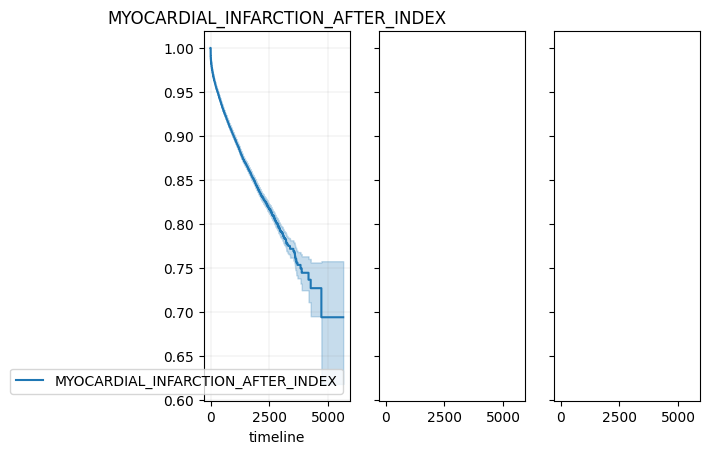

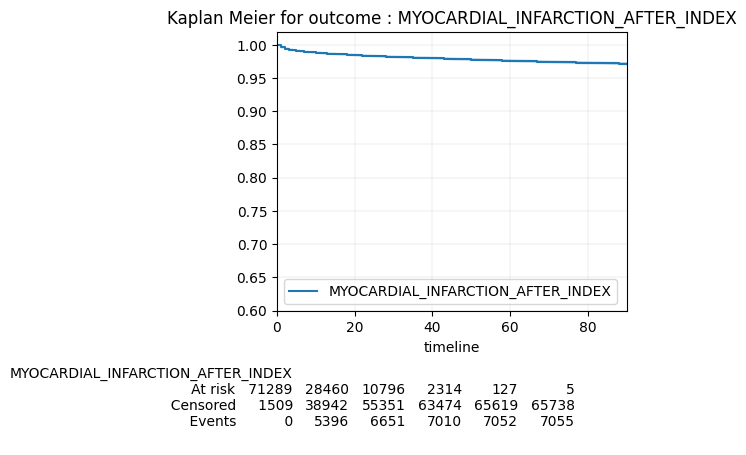

In [23]:
import datetime
from phenex.reporting import TimeToEvent
from phenex.phenotypes import DeathPhenotype


end_of_followup = TimeRangePhenotype(
    name='end_of_followup',
    relative_time_range=RelativeTimeRangeFilter(when='after')
)

death_right_censor = DeathPhenotype(
    name = 'death_censoring',
    domain='DEATH',
    relative_time_range=f_postindex
)
right_censor_phenotypes = [end_of_followup, death_right_censor]


tte = TimeToEvent(
    right_censor_phenotypes = right_censor_phenotypes, 
    end_of_study_period=datetime.date(2025,12,12)
)

tte.execute(cohort)


tte.plot_single_kaplan_meier(xlim=[0,90], outcome_index=0)

